<a href="https://colab.research.google.com/github/remifol/SystematicReview/blob/master/W2V_HomeTrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this model directly in the browser with zero setup, open it in [Colab here](https://colab.research.google.com/github/sararob/keras-wine-model/blob/master/keras-wide-deep.ipynb).

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
import os
import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import tensorflow as tf
import time
import gensim
import random

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from gensim.models.word2vec import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences
layers = keras.layers

from google.colab import drive
drive.mount('/content/drive')
Path = 'drive/My Drive/Projet de maitrise/Revue systématique/Automatisation/Algorithme/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def encode(word_tokens, w2v_model):
  #return a list of ID to be later embeded by a custom gensim keras layer
  #return nothing when word is not in index
  return np.asarray([w2v_model.vocab[word].index for word in word_tokens if word in w2v_model.vocab])

def embed(cleanedstring, model):
  tokens = nltk.word_tokenize(cleanedstring)
  embeded = []
  for word in tokens:
      try :
        embeded.append(w2v_model.get_vector(word))
      except KeyError: #unkown word
        continue
        #embeded.append(np.zeros(w2v_model.vector_size)) #unkown tag
  return np.asarray(embeded)

def pad(serie, max_length):
  return serie.apply(lambda x:np.pad(x,((0,max_length-x.shape[0])),'constant',constant_values=0))
  

def triplet_loss(margin):
    def loss(y_true,y_pred):
        label = keras.backend.sum(y_true, axis=-1)
        return tf.contrib.losses.metric_learning.triplet_semihard_loss(embeddings = y_pred, labels = label, margin = margin)
   
    return loss

def embedding_matrix(tokenizer, w2v_model, MAX_NB_WORD):
  word_index = tokenizer.word_index
  nb_words = min(MAX_NB_WORDS, len(word_index))+1

  matrix = np.zeros((nb_words, w2v_model.vector_size))
  for word, i in word_index.items():
      if word in w2v_model.vocab:
          matrix[i] = w2v_model.word_vec(word)
  
  PercentUnkownWord = np.sum(np.count_nonzero(matrix,axis=1) == 0) / len(word_index.items())
  print('There is {0:2.2f}% of unkown words.'.format(PercentUnkownWord*100))
  
  return matrix


def embedding_layer(matrix, MAX_SEQUENCE_LENGTH):
  layer = layers.Embedding(matrix.shape[0], # or len(word_index) + 1
                              matrix.shape[1], # or EMBEDDING_DIM,
                              weights=[matrix],
                              input_length=MAX_SEQUENCE_LENGTH,
                              trainable=False)
  return layer

In [0]:
#Extraction of the pre-formated tsv data
Data = pd.read_csv(Path+'epc-ir.clean.tsv', sep = '\t',names = ['ReviewSubject', 'Unknown', 'PMID','AbstractTriageStatus', 'ArticleTriageStatus'])
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] == 'I'] = 1 #included
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] != 1] = 0 #excluded
Subjects = Data['ReviewSubject'].unique().tolist()

#Loading of W2V model
print('Loading of the W2V model...')
#w2v_model = gensim.models.KeyedVectors.load_word2vec_format(Path + "Models/GoogleNews-vectors-negative300.bin.gz", binary=True)
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(Path + "Models/pubmed2018_w2v_200D.bin", binary=True)
#w2v_model = gensim.models.KeyedVectors.load_word2vec_format(Path + "Models/"+ValidationSubject+"_word2vec_128.bin", binary=True)
print('Model loaded.')

#Randomly select one subject to be the cross validation subject
ValidationSubject = Subjects.pop(np.random.randint(0,len(Subjects)))
ValidationArticles = pd.read_csv(Path+ValidationSubject+'.csv')
#ValidationArticles['W2V_article'] = ValidationArticles['CleanedArticle'].apply(lambda x:embed(x,w2v_model))
#ValidationArticles['W2V_article_index'] = ValidationArticles['StemmedArticle'].apply(lambda x:embed(x,w2v_model))
print('Validation Subject: '+ ValidationSubject + ': '+ str(len(ValidationArticles)) + 'article is done')                                                
  
#Create a pool of the rest of the systematic reviews
Pooled_Systematic_Reviews = pd.read_csv(Path+Subjects[0]+'.csv')
print(Subjects[0]+': '+ str(len(Pooled_Systematic_Reviews)) + 'article is done')

for i in range(1,len(Subjects)):
  Review_Temp = pd.read_csv(Path+Subjects[i]+'.csv')
  #Change 0/1 label to article unique values
  Review_Temp['Label'][Review_Temp['Label']==0] = 2*i
  Review_Temp['Label'][Review_Temp['Label']==1] = 2*i+1
  print(Subjects[i]+': '+ str(len(Review_Temp)) + ' article is done')
  Pooled_Systematic_Reviews = Pooled_Systematic_Reviews.append(Review_Temp)

Pooled_Systematic_Reviews = Pooled_Systematic_Reviews.reset_index(drop=True)
#Pooled_Systematic_Reviews['W2V_article'] = Pooled_Systematic_Reviews['Article'].apply(lambda x:embed(x,w2v_model))
#Pooled_Systematic_Reviews['W2V_article_index'] = Pooled_Systematic_Reviews['StemmedArticle'].apply(lambda x:embed(x,w2v_model))
print('Pooled systematic reviews embeded.')

Loading of the W2V model...
Model loaded.
Validation Subject: CalciumChannelBlockers: 1095article is done
ACEInhibitors: 2114article is done
ADHD: 754 article is done
Antihistamines: 185 article is done
AtypicalAntipsychotics: 922 article is done
BetaBlockers: 1807 article is done
Estrogens: 190 article is done
NSAIDS: 179 article is done
Opiods: 1666 article is done
OralHypoglycemics: 380 article is done
ProtonPumpInhibitors: 1089 article is done
SkeletalMuscleRelaxants: 1321 article is done
Statins: 2693 article is done
Triptans: 530 article is done
UrinaryIncontinence: 174 article is done
Pooled systematic reviews embeded.


In [0]:
coll#GLobal Variables
Last_Layer_size = 32
TestSize = 0.5
LearningRate = 0.001
dim = w2v_model.vector_size

In [0]:
iteration = 5
TestSizes = [0.7,0.5,0.3,0.1]


#Extraction of the pre-formated tsv data
Data = pd.read_csv(Path+'epc-ir.clean.tsv', sep = '\t',names = ['ReviewSubject', 'Unknown', 'PMID','AbstractTriageStatus', 'ArticleTriageStatus'])
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] == 'I'] = 1 #included
Data['AbstractTriageStatus'][Data['AbstractTriageStatus'] != 1] = 0 #excluded
Subjects = Data['ReviewSubject'].unique().tolist()


#SVM
ResultDict_SVM = {}
ResultDict_RegLog = {}
for Subject in Subjects:
  ValidationArticles = pd.read_csv(Path+Subject+'.csv')
  ValidationArticles['W2V_article'] = ValidationArticles['CleanedArticle'].apply(lambda x:embed(x,w2v_model))
  print(Subject)
  for TestSize in TestSizes:
    print(str(TestSize))

    Acc = np.zeros(iteration)
    Sn  = np.zeros(iteration)
    Sp = np.zeros(iteration)
    F1 = np.zeros(iteration)
    for i in range(iteration):
      #SVM prediction with W2V
      X_train, X_test, y_train, y_test = train_test_split(ValidationArticles['W2V_article'], ValidationArticles['Label'], test_size=TestSize)

      #Transform Data to use each word as a feature
      y_train = np.concatenate([np.ones(X_train[i].shape[0])*y_train[i] for i in list(X_train.index.values)], axis=0)
      X_train = np.concatenate(X_train.tolist(), axis=0)

      svm_W2V = linear_model.SGDClassifier(loss = 'hinge',
                                          penalty = 'l2', 
                                          max_iter = 10000, 
                                          tol=1e-4, class_weight = 'balanced'
                                          )
 
      _ = svm_W2V.fit(X_train, y_train)

      y_predict = [np.sign(svm_W2V.decision_function(test_value).sum())/2 +0.5 for test_value in X_test]

      Acc[i] = accuracy_score(y_test,y_predict, normalize=True)
      Sn[i] = recall_score(y_test,y_predict, pos_label=1)
      Sp[i] = recall_score(y_test,y_predict, pos_label=0)
      F1[i] = f1_score(y_test,y_predict, pos_label=1)
    print('Accuracy : {0:0.4f}, Sensitivity : {1:0.4f}, Specificity : {2:0.4f}, F1 score : {3:0.4f}'.format(np.mean(Acc),np.mean(Sn),np.mean(Sp),np.mean(F1)))
      
    ResultDict_SVM.update({(Subject,str(TestSize),'SVM','Sensitivity'): Sn,
                      (Subject,str(TestSize),'SVM','Specificity'): Sp,
                      (Subject,str(TestSize),'SVM','Accuracy'): Acc,
                      (Subject,str(TestSize),'SVM','F1_score'): F1})
    
  #Logistic Regression
  for TestSize in TestSizes:
    print(TestSize)

    Acc = np.zeros(iteration)
    Sn  = np.zeros(iteration)
    Sp = np.zeros(iteration)
    F1 = np.zeros(iteration)
    for i in range(iteration):
  
      #Logistic regression prediction with W2V
      X_train, X_test, y_train, y_test = train_test_split(ValidationArticles['W2V_article'], ValidationArticles['Label'], test_size=TestSize)

      #Transform Data to use each word as a feature
      y_train = np.concatenate([np.ones(X_train[i].shape[0])*y_train[i] for i in list(X_train.index.values)], axis=0)
      X_train = np.concatenate(X_train.tolist(), axis=0)

      LogReg_W2V = linear_model.SGDClassifier(loss = 'log',
                                              penalty = 'l2', 
                                              max_iter = 10000, 
                                              tol=1e-4, class_weight = 'balanced'
                                              )
      _ = LogReg_W2V.fit(X_train, y_train)

      y_predict = [np.sign(LogReg_W2V.decision_function(test_value).sum())/2 +0.5 for test_value in X_test]

      Acc[i] = accuracy_score(y_test,y_predict, normalize=True)
      Sn[i] = recall_score(y_test,y_predict, pos_label=1)
      Sp[i] = recall_score(y_test,y_predict, pos_label=0)
      F1[i] = f1_score(y_test,y_predict, pos_label=1)
      
    print('Accuracy : {0:0.4f}, Sensitivity : {1:0.4f}, Specificity : {2:0.4f}, F1 score : {3:0.4f}'.format(np.mean(Acc),np.mean(Sn),np.mean(Sp),np.mean(F1)))

    ResultDict_RegLog.update({(Subject,str(TestSize),'Log','Sensitivity'): Sn,
                              (Subject,str(TestSize),'Log','Specificity'): Sp,
                              (Subject,str(TestSize),'Log','Accuracy'): Acc,
                              (Subject,str(TestSize),'Log','F1_score'): F1})
    
with pd.ExcelWriter(Path+'W2V_Google_output.xlsx') as writer:  # doctest: +SKIP
  pd.DataFrame(ResultDict_SVM).to_excel(writer, sheet_name='SVM W2V')
  pd.DataFrame(ResultDict_RegLog).to_excel(writer, sheet_name='RegLog W2V')

In [0]:
#Triplet loss with a W2V on ONE article

#GLobal Variables
Last_Layer_size = 128
TestSize = 0.5
LearningRate = 0.0001
dim = w2v_model.vector_size

#formatting data to numerical tokens with pre-trained tokenizer
Article_token = tokenizer.texts_to_sequences(ValidationArticles['CleanedArticle'])
Article_Token = keras.preprocessing.sequence.pad_sequences(Article_token, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='post', truncating='post', value=0.0)

X_train, X_test, y_train, y_test = train_test_split(Article_Token, ValidationArticles['Label'], test_size=TestSize)

# Define our deep model with the Functional API
Inputs = layers.Input(shape = (X_train.shape[1],))

deep_net = embedding_layer(Inputs)
deep_net = layers.Bidirectional(layers.GRU(Last_Layer_size),merge_mode = 'sum')(deep_net)
deep_net = layers.Flatten()(deep_net)
deep_net = layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=1))(deep_net)

deep_model_gpu = keras.Model(inputs=Inputs, outputs=deep_net)
deep_model_gpu.summary()

deep_model_gpu.compile(loss=triplet_loss(margin=0.5), optimizer=keras.optimizers.Adam(lr=LearningRate))

deep_model_gpu.fit(x = X_train, y = y_train, batch_size = 128, epochs = 24, verbose=1)

### Switch to TPU to train the model faster
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# tf.logging.set_verbosity(tf.logging.INFO)

# deep_model = tf.contrib.tpu.keras_to_tpu_model(
#     deep_model_gpu,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

# deep_model.fit(x = X_train, y = y_train, batch_size = 128, epochs = 48, verbose=1)


# deep_model.save_weights(Path + 'tpu_model.h5', overwrite=True)
# deep_model_gpu.load_weights(Path + 'tpu_model.h5',)


x_train_embed = deep_model_gpu.predict(X_train)
x_test_embed = deep_model_gpu.predict(X_test)

#create classifier to predict class
Deep_model_SVM = linear_model.SGDClassifier(loss = 'log', 
                                     max_iter =  10000,
                                     tol=1e-5,
                                     class_weight = 'balanced'
                                           )

_ = Deep_model_SVM.fit(x_train_embed, y_train)

y_predict = Deep_model_SVM.predict(x_test_embed)

print('With a deep learning model with triplet loss, on '+ ValidationSubject+' based on a W2V model, with a test size of {0} text we obtain:'.format(TestSize))
Acc = accuracy_score(y_test,y_predict, normalize=True)
print('Accuracy : {0:0.4f}'.format(Acc))

Sn = recall_score(y_test,y_predict, pos_label=1)
print('Sensitivity : {0:0.4f}'.format(Sn))

Sp = recall_score(y_test,y_predict, pos_label=0)
print('Specificity : {0:0.4f}'.format(Sp))


F1 = f1_score(y_test,y_predict, pos_label=1)
print('F1 score : {0:0.4f}'.format(F1))

In [0]:
#Triplet loss with a W2V
MAX_NB_WORDS = 500000
MAX_SEQUENCE_LENGTH = 100
Last_Layer_size = 64
LearningRate = 0.001
Train_Frac = 0.5
Article_type = 'CleanedArticle'#'StemmedArticle'


tokenizer = keras.preprocessing.text.Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(Pooled_Systematic_Reviews[Article_type].append(ValidationArticles[Article_type]))
Emb_Matrix = embedding_matrix(tokenizer, w2v_model, MAX_NB_WORDS)

#formatting data to numerical tokens with pre-trained tokenizer
Article_token = tokenizer.texts_to_sequences(Pooled_Systematic_Reviews[Article_type])
X_train = keras.preprocessing.sequence.pad_sequences(Article_token, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='post', truncating='post', value=0.0)
y_train = Pooled_Systematic_Reviews['Label']

There is 2.96% of unkown words.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 200)          6113000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 100)           100100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_______

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


INFO:tensorflow:TPU -> CPU clipvalue: 0.5
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False
With a deep learning model with triplet loss trained on all SR, tested CalciumChannelBlockers based on a BOW from stemmed, with a test size of 0.5 text we obtain:
Accuracy : 0.6679
Sensitivity : 0.4444
Specificity : 0.7409
F1 score : 0.3974


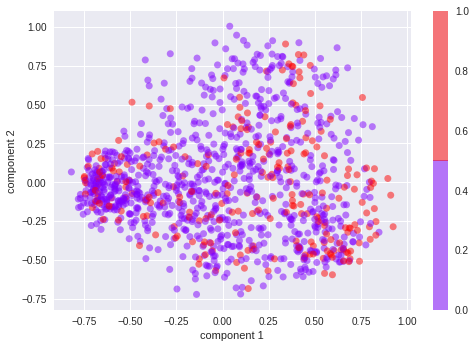

In [0]:
# Define our deep model with the Functional API
Inputs = layers.Input(shape = (X_train.shape[1],))

deep_net = embedding_layer(Emb_Matrix, MAX_SEQUENCE_LENGTH)(Inputs)

#Model from Kim and al, 2014
deep_net = layers.Conv1D(filters = 100,kernel_size = 5)(deep_net)
deep_net = layers.GlobalMaxPooling1D()(deep_net)
deep_net = layers.Dropout(0.3)(deep_net)
deep_net = layers.Dense(Last_Layer_size,activity_regularizer=keras.regularizers.l2(0.01))(deep_net)
#deep_net = layers.Bidirectional(layers.GRU(Last_Layer_size, activation=None))(deep_net)


#Adapted from Manatthan LSTM
#deep_net = layers.Bidirectional(layers.GRU(Last_Layer_size, activation=None))(deep_net)
deep_net = layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=1))(deep_net)

deep_model_gpu = keras.Model(inputs=Inputs, outputs=deep_net)

#Tranferring to TPU for rapidity
deep_model_gpu.compile(loss=triplet_loss(margin=0.8), optimizer=keras.optimizers.Adam(lr=LearningRate, clipvalue=0.5))
deep_model_gpu.summary()

#deep_model_gpu.fit(x = X_train, y = y_train, batch_size = 2048, epochs = 400, verbose=1)

# # Switch to TPU to train the model faster
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

deep_model = tf.contrib.tpu.keras_to_tpu_model(
    deep_model_gpu,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

deep_model.fit(x = X_train, y = y_train, batch_size = 64*8, epochs = 100, verbose=1)

deep_model.save_weights(Path + 'tpu_model.h5', overwrite=True)
deep_model_gpu.load_weights(Path + 'tpu_model.h5',)

#formatting data to numerical tokens with pre-trained tokenizer
Article_token = tokenizer.texts_to_sequences(ValidationArticles[Article_type])
X_train = keras.preprocessing.sequence.pad_sequences(Article_token, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='post', truncating='post', value=0.0)

#application to the validation systematic review
X_train, X_test, y_train, y_test = train_test_split(X_train, ValidationArticles['Label'], train_size=Train_Frac)

deep_model.save_weights(Path + 'tpu_model.h5', overwrite=True)
deep_model_gpu.load_weights(Path + 'tpu_model.h5',)


#predict
x_train_embed = deep_model_gpu.predict(X_train)
x_test_embed = deep_model_gpu.predict(X_test)

#create classifier to predict class
Deep_model_SVM = linear_model.SGDClassifier(loss = 'log',
                                     penalty = 'l1', 
                                     max_iter =  10000,
                                     tol=1e-5,
                                     class_weight = 'balanced')

_ = Deep_model_SVM.fit(x_train_embed, y_train)

y_predict = Deep_model_SVM.predict(x_test_embed)

print('With a deep learning model with triplet loss trained on all SR, tested '+ ValidationSubject+' based on a BOW from stemmed, with a test size of {0} text we obtain:'.format(Train_Frac))
Acc = accuracy_score(y_test,y_predict, normalize=True)
print('Accuracy : {0:0.4f}'.format(Acc))

Sn = recall_score(y_test,y_predict, pos_label=1)
print('Sensitivity : {0:0.4f}'.format(Sn))

Sp = recall_score(y_test,y_predict, pos_label=0)
print('Specificity : {0:0.4f}'.format(Sp))


F1 = f1_score(y_test,y_predict, pos_label=1)
print('F1 score : {0:0.4f}'.format(F1))

#PCA visualisation
projected = PCA(2).fit_transform(np.concatenate((x_train_embed,x_test_embed), axis=0))

plt.scatter(projected[:, 0], projected[:, 1],
            c=np.concatenate((y_train,y_test), axis=0), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

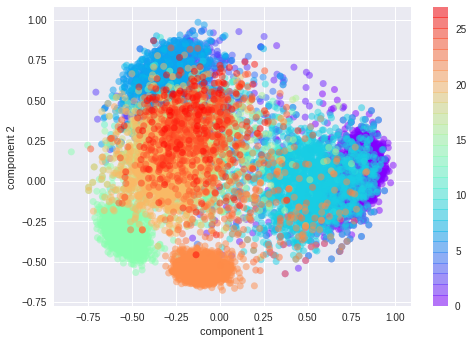

In [0]:
#PCA visualisation of all
Article_token_train = tokenizer.texts_to_sequences(Pooled_Systematic_Reviews[Article_type])
X_train_train  = keras.preprocessing.sequence.pad_sequences(Article_token_train, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='post', truncating='post', value=0.0)
X_train_train = x_train_embed = deep_model_gpu.predict(X_train_train)
y_train_train  = Pooled_Systematic_Reviews['Label']
N_cat = y_train_train.unique()



projected = PCA(2).fit_transform(X_train_train)

plt.scatter(projected[:, 0], projected[:, 1],
            c=y_train_train.values, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', len(N_cat)))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Below: laboratory and testing

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


INFO:tensorflow:Querying Tensorflow master (grpc://10.108.28.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4328910074215223545)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16669441419892540370)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16891765689601879838)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 8928923984180436632)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2859533376061816610)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

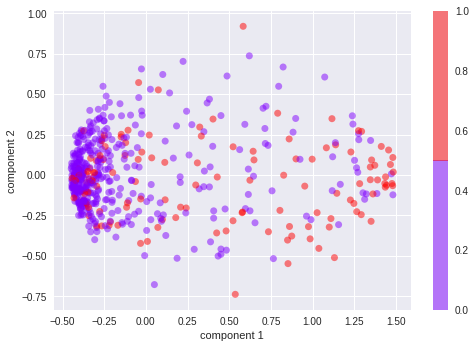

In [0]:
#CONTINUE TRAINING ON MODEL

#formatting data to numerical tokens with pre-trained tokenizer
Article_token = tokenizer.texts_to_sequences(ValidationArticles['CleanedArticle'])
Article_Token = keras.preprocessing.sequence.pad_sequences(Article_token, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='post', truncating='post', value=0.0)

X_train, X_test, y_train, y_test = train_test_split(Article_Token, ValidationArticles['Label'], train_size=Train_Frac)

deep_model_gpu = keras.Model(inputs=Inputs, outputs=deep_net)

#Tranferring to TPU for rapidity
deep_model_gpu.compile(loss=triplet_loss(margin=0.8), optimizer=keras.optimizers.Adam(lr=LearningRate, clipvalue=0.5))

deep_model_gpu.load_weights(Path + 'tpu_model.h5',)

### Switch to TPU to train the model faster
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

deep_model = tf.contrib.tpu.keras_to_tpu_model(
    deep_model_gpu,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

deep_model.fit(x = X_train, y = y_train, batch_size = 32*8, epochs = 50, verbose=1)

deep_model.save_weights(Path + 'tpu_model_continue.h5', overwrite=True)
deep_model_gpu.load_weights(Path + 'tpu_model_continue.h5',)

x_train_embed = deep_model_gpu.predict(X_train)
x_test_embed = deep_model_gpu.predict(X_test)

#create classifier to predict class
Deep_model_SVM = linear_model.SGDClassifier(loss = 'log', 
                                     max_iter =  10000,
                                     tol=1e-5,
                                     class_weight = 'balanced'
                                           )

_ = Deep_model_SVM.fit(x_train_embed, y_train)

y_predict = Deep_model_SVM.predict(x_test_embed)

print('With a deep learning model with triplet loss, on '+ ValidationSubject+' based on a W2V model, with a test size of {0} text we obtain:'.format(Train_Frac))
Acc = accuracy_score(y_test,y_predict, normalize=True)
print('Accuracy : {0:0.4f}'.format(Acc))

Sn = recall_score(y_test,y_predict, pos_label=1)
print('Sensitivity : {0:0.4f}'.format(Sn))

Sp = recall_score(y_test,y_predict, pos_label=0)
print('Specificity : {0:0.4f}'.format(Sp))


F1 = f1_score(y_test,y_predict, pos_label=1)
print('F1 score : {0:0.4f}'.format(F1))

#PCA visualisation
projected = PCA(2).fit_transform(x_test_embed)

plt.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();